In [51]:
import numpy as np
import pandas as pd

import spectral as sp
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [5]:
def count_occurrence(arr):
    unique_elements, counts = np.unique(arr, return_counts=True)
    for element, count in zip(unique_elements, counts):
        print(f"{element} = {count}")

In [6]:
pines_in = np.load("indianpinearray.npy")
pines_out = np.load("IPgt.npy")
r_in, c_in, band = pines_in.shape
r_out, c_out = pines_out.shape
c = np.unique(pines_out)

In [7]:
print(f'Dataset Shape: {r_in, c_in, band}\nGroundtruth Shape: {r_out, c_out}\nNumber of Bands: {band}\nClasses: {c}')
count_occurrence(pines_out)

Dataset Shape: (145, 145, 200)
Groundtruth Shape: (145, 145)
Number of Bands: 200
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
0 = 10776
1 = 46
2 = 1428
3 = 830
4 = 237
5 = 483
6 = 730
7 = 28
8 = 478
9 = 20
10 = 972
11 = 2455
12 = 593
13 = 205
14 = 1265
15 = 386
16 = 93


<Figure size 600x400 with 0 Axes>

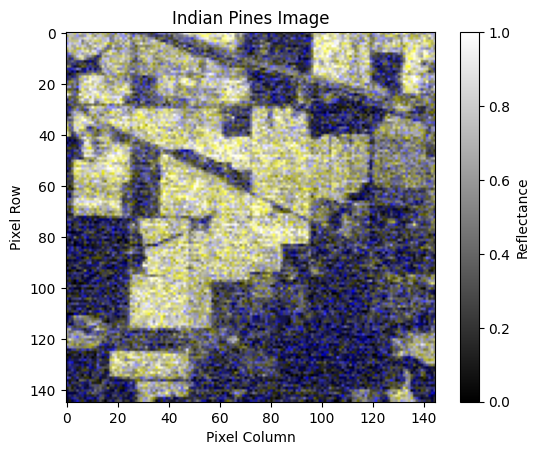

In [56]:
plt.figure(figsize=(6, 4))
sp.imshow(pines_in, (145, 145, 199), stretch=(0.01, 0.99))
plt.colorbar(label='Reflectance')
plt.title('Indian Pines Image')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()

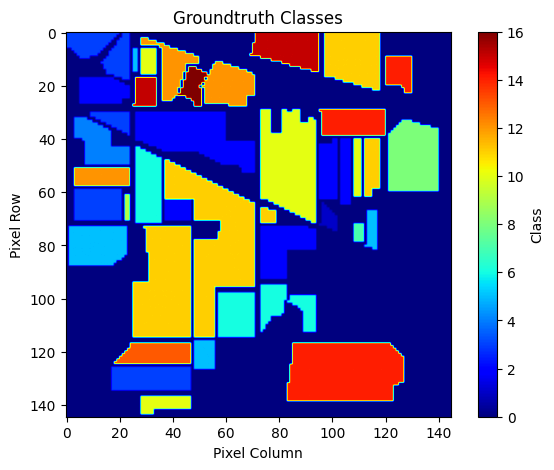

In [55]:
plt.figure(figsize=(7, 5))
plt.imshow(pines_out, cmap='jet')
plt.colorbar(label='Class')
plt.title('Groundtruth Classes')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()

In [10]:
pix_row = pd.Series([i for i in range(145) for _ in range(145)])
pix_col = pd.Series([j for _ in range(145) for j in range(145)])
bands = [pd.Series(pines_in[:, :, i].ravel()) for i in range(pines_in.shape[2])]

df = pd.concat(
    [pd.Series(pix_row.values.reshape(-1)), 
     pd.Series(pix_col.values.reshape(-1)), 
     *bands, 
     pd.Series(pines_out.reshape(-1))], 
    axis=1)

df.columns = ['pixel_row', 'pixel_col'] + [f'band-{i+1}' for i in range(pines_in.shape[2])] + ['class']

df.head()

,pixel_row,pixel_col,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,...,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,0,0,3172,4142,4506,4279,4782,5048,5213,5106,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,0,1,2580,4266,4502,4426,4853,5249,5352,5353,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,0,2,3687,4266,4421,4498,5019,5293,5438,5427,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,0,3,2749,4258,4603,4493,4958,5234,5417,5355,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,0,4,2746,4018,4675,4417,4886,5117,5215,5096,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [11]:
X = df.loc[:, 'band-1':'band-200'].values
y = df['class'].values

X.shape, y.shape


((21025, 200), (21025,))

## Dimesionality Reduction Play

PCA

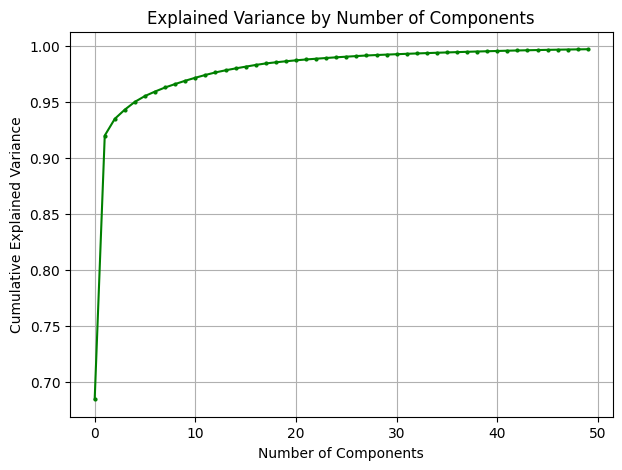

In [12]:
pca_init = PCA(n_components = 50).fit(X)

plt.figure(figsize=(7, 5))
plt.plot(np.cumsum(pca_init.explained_variance_ratio_), marker='o', linestyle='-', color='green', markersize=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

In [13]:
pca = PCA(n_components=30)
pca_fit = pca.fit_transform(X)

X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(pca_fit, y,  range(X.shape[0]), test_size = 0.15)

X_train.shape, X_test.shape

((17871, 30), (3154, 30))

## Model Development Play

SVM

In [14]:
def svm_rbf(X_train, y_train, X_test, y_test, silence=False):
    svm = SVC(kernel='rbf', degree = 10, gamma='scale', cache_size=1024*7) # radial basis function

    svm.fit(X_train, y_train)
    score = svm.score(X_test, y_test)
    y_pred = svm.predict(X_test)

    if not silence:
        print("Accuracy is: %.2f %%" % (score * 100))
    return y_pred, score

In [15]:
def svm_gs(X_train, y_train, X_test, y_test, silence=False):
    svm = SVC(kernel='rbf') # radial basis function

    C_range = np.logspace(-2, 10, 1)
    gamma_range = np.logspace(-9, 3, 1)
    param_grid = dict(gamma=gamma_range, C=C_range)

    svm_gridsearch = GridSearchCV(svm, param_grid, cv=2)

    svm_gridsearch.fit(X_train, y_train)
    score = svm_gridsearch.score(X_test, y_test)
    y_pred = svm_gridsearch.predict(X_test)

    if not silence:
        print("Accuracy is: %.2f %%" % (score * 100))
        print("With n: gamma: %i and C: %i" % (svm_gridsearch.best_params_['gamma'], svm_gridsearch.best_params_['C']))
    return y_pred, score

In [16]:
def knn_euclid(X_train, y_train, X_test, y_test, silence=False):
    knn = KNeighborsClassifier(metric='euclidean', n_neighbors = 10)

    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    y_pred = knn.predict(X_test)

    if not silence:
        print("Accuracy is: %.2f %%" % (score * 100))
        
    return y_pred, score

In [17]:
def knn_gs(X_train, y_train, X_test, y_test, silence=False):
    knn = KNeighborsClassifier(metric='euclidean')

    param_grid = {'n_neighbors': np.arange(1, 20)}
    knn_gridsearch = GridSearchCV(knn, param_grid, cv=2)

    knn_gridsearch.fit(X_train, y_train)
    score = knn_gridsearch.score(X_test, y_test)
    y_pred = knn_gridsearch.predict(X_test)

    if not silence:
        print("Accuracy is: %.2f %%" % (score * 100))
        print("With n: %i " % knn_gridsearch.best_params_['n_neighbors'])
    return y_pred, score

In [18]:
def random_forest(X_train, y_train, X_test, y_test, silence=False):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    y_pred = rf.predict(X_test)

    if not silence:
        print("Accuracy is: %.2f %%" % (score * 100))
    return y_pred, score

In [84]:
def random_forest_gs(X_train, y_train, X_test, y_test, silence=False):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    param_grid = {'n_estimators': np.arange(20, 200, 20)}
    rf_gridsearch = GridSearchCV(rf, param_grid, cv=2)

    rf_gridsearch.fit(X_train, y_train)
    score = rf_gridsearch.score(X_test, y_test)
    y_pred = rf_gridsearch.predict(X_test)

    if not silence:
        print("Accuracy is: %.2f %%" % (score * 100))
        print("With n: %i " % rf_gridsearch.best_params_['n_estimators'])
    return y_pred, score

In [63]:
y_svm, score_svm = svm_rbf(X_train, y_train, X_test, y_test)

Accuracy is: 71.75 %


100%|██████████| 2/2 [00:00<?, ?it/s]


In [21]:
y_svm_gs, score_svm_gs = svm_gs(X_train, y_train, X_test, y_test)

Accuracy is: 52.69 %
With n: gamma: 0 and C: 0


In [22]:
y_knn, score_knn = knn_euclid(X_train, y_train, X_test, y_test)

Accuracy is: 72.51 %


In [23]:
y_knn_gs, score_knn_gs = knn_gs(X_train, y_train, X_test, y_test)

Accuracy is: 72.64 %
With n: 12 


In [81]:
y_rf, score_rf = random_forest(X_train, y_train, X_test, y_test)

Accuracy is: 77.27 %


In [85]:
y_rf_gs, score_rf_gs = random_forest_gs(X_train, y_train, X_test, y_test)

Accuracy is: 77.33 %
With n: 140 


## Model Evaluation Play

In [86]:
import scikitplot as skplt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import plotly.graph_objects as go
from sklearn.metrics import log_loss, roc_auc_score, matthews_corrcoef, cohen_kappa_score
from sklearn.preprocessing import LabelBinarizer

In [87]:
def plot_classification_report(y_pred, title):
    print('Classification Report - '+ title)
    print('Accuracy: %.2f %%' % (accuracy_score(y_test, y_pred) * 100))
    print(classification_report(y_test, y_pred))

    skplt.metrics.plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix - '+title, figsize=(7,5), cmap='Greens')

In [100]:
def plot_classification_map(y_pred, title):
    clmap = [0]*X.shape[0]

    clmap = [y[idx] if idx in indices_train else clmap[i] for i, idx in enumerate(range(X.shape[0]))]

    clmap = [y_pred[indices_test.index(i)] if i in indices_test else clmap[i] for i in range(X.shape[0])]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(np.array(clmap).reshape((145, 145)), cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.title('Classification Map - ' + title)

    plt.subplot(1, 2, 2)
    plt.imshow(pines_out, cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.title('True Map')

    plt.tight_layout()
    plt.show()

In [104]:
def other_metrics(y_pred, title):
    loss = log_loss(y_test, y_pred)

    lb = LabelBinarizer()
    lb.fit(y_test)

    y_true_bin = lb.transform(y_test)
    y_pred_bin = lb.transform(y_pred)

    roc_auc = roc_auc_score(y_true_bin, y_pred_bin, multi_class='ovr')

    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    print('Other Metrics - ' + title)
    print('Log Loss: {}'.format(loss))
    print('AUC-ROC: {}'.format(roc_auc))
    print('Matthews Correlation Coefficient: {}'.format(mcc))
    print("Cohen's Kappa: {}".format(kappa))

Classification Report - Random Forest
Accuracy: 77.27 %
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1662
           1       1.00      0.62      0.77         8
           2       0.65      0.71      0.68       205
           3       0.84      0.54      0.66       124
           4       0.65      0.27      0.38        41
           5       0.88      0.68      0.77        68
           6       0.84      0.68      0.75       110
           7       1.00      0.17      0.29         6
           8       0.95      0.98      0.97        85
           9       0.00      0.00      0.00         4
          10       0.68      0.69      0.68       131
          11       0.72      0.81      0.77       358
          12       0.75      0.56      0.64        75
          13       0.96      0.88      0.92        25
          14       0.59      0.42      0.49       190
          15       0.00      0.00      0.00        53
          16       0.86  

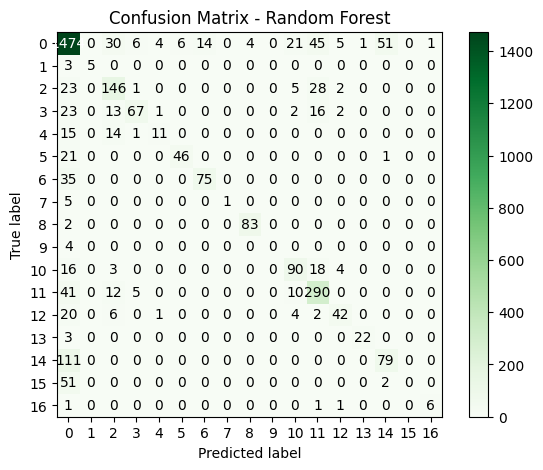

In [90]:
plot_classification_report(y_rf, 'Random Forest')

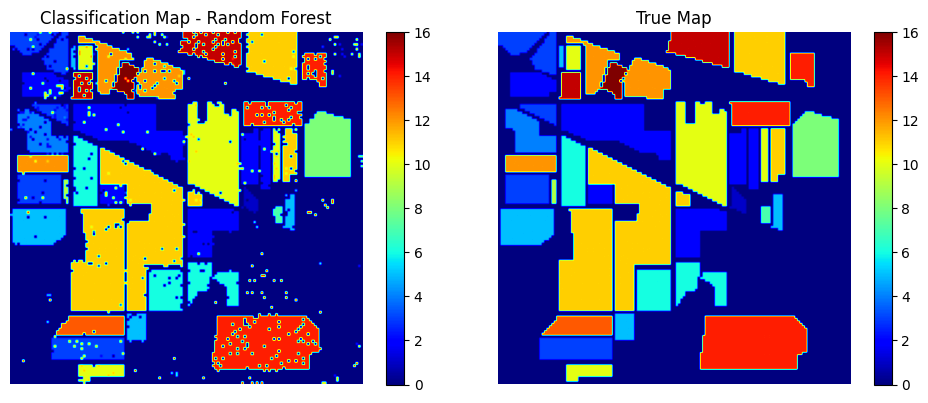

In [102]:
plot_classification_map(y_rf, 'Random Forest')

In [107]:
other_metrics(y_rf, 'Random Forest')

ValueError: y_true and y_pred contain different number of classes 17, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]